## Import Modules

In [1]:
# Image and video processing
import cv2
import mediapipe as mp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns  

# Data handling and utilities
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import random
from pathlib import Path
import pickle
import zipfile

# Machine learning (XGBoost)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# TensorFlow and Keras (for CNNs)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [2]:
# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is not using the GPU.")


TensorFlow is not using the GPU.


## Set Paramaters

In [3]:
letters = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]

letters_dict_mnist = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P',
    15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X',
    23: 'Y', 
}

letters_dict_asl = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P',
    16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z'
}

# Get the current working directory 
base_dir = Path().resolve()  

## Unzip the Data

In [4]:
def unzip_file(zip_file_path, extract_to_directory):
    # Ensure the extraction directory exists
    os.makedirs(extract_to_directory, exist_ok=True)
    
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extract_to_directory)
    
    print(f"Unzipped {zip_file_path} to {extract_to_directory}")

In [5]:
# Get the mnist Data
# Define the folder path for the data
data_folder_path = Path("E:/Signify/Datasets")  # Set base directory path

# Define the path for the MNIST test data folder
mnist_path = Path(data_folder_path) / 'sign_mnist_test'

# Check if the folder exists
if mnist_path.is_dir():
    print('folder already exists')
    pass  
else:
    # If the folder does not exist, unzip the file
    zip_file = data_folder_path / 'signs.zip'  # Use your provided zip file path
    extract_dir = data_folder_path
    
    # Assuming unzip_file is a defined function that extracts the zip file
    unzip_file(zip_file, extract_dir)


folder already exists


In [6]:
# Get the ASL Data
# Define the folder path for the ASL data
data_folder_path = Path("E:/Signify/Datasets")  # Set base directory path for ASL data

# Define the path for the ASL train data folder
asl_path = Path(data_folder_path) / 'asl_alphabet_train'

# Check if the folder exists
if asl_path.is_dir():
    print('folder already exists')
    pass  
else:
    # If the folder does not exist, unzip the file
    zip_file = data_folder_path / 'asl_alphabet_train.zip'  # Use your provided zip file path
    extract_dir = data_folder_path
    
    # Assuming unzip_file is a defined function that extracts the zip file
    unzip_file(zip_file, extract_dir)


folder already exists


## MNIST

In [7]:
# Define paths relative to the base directory
base_dir = Path("E:/Signify/Datasets")

# Correct file paths for the train and test datasets
train_path = base_dir / 'sign_mnist_train.csv'  # Use the file in the root folder
test_path = base_dir / 'sign_mnist_test.csv'    # Use the file in the root folder



# Get the train and test Data
df_mnist_train = pd.read_csv(train_path)
df_mnist_test = pd.read_csv(test_path)

### EDA

In [8]:
df_mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [9]:
df_mnist_train.shape

(27455, 785)

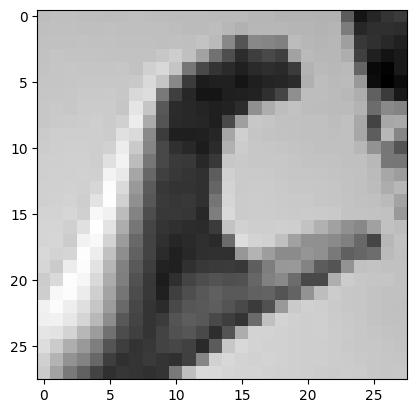

In [10]:
# See what one image would look like
hand_1 = np.array(df_mnist_train.iloc[2,1:]).reshape(28,28)
plt.imshow(hand_1, cmap='gray')

### Feature Creation

### Split the Data

In [11]:
# Make the train set
X_df_mnist_train = df_mnist_train.iloc[:,1:]
y_df_mnist_train = df_mnist_train.iloc[:,0]

# Make the test set
X_df_mnist_test = df_mnist_test.iloc[:,1:]
y_df_mnist_test = df_mnist_test.iloc[:,0]

# Encode the labels
le = LabelEncoder()
y_df_mnist_train_xgb = le.fit_transform(y_df_mnist_train)
y_df_mnist_test_xgb = le.transform(y_df_mnist_test)

### Train an Xgboost model

In [12]:
from pathlib import Path
import os
import pickle
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Define the file name for the model
model_filename = base_dir / 'models' / 'xgboost_model_mnist.pkl'

# Ensure the 'models' directory exists
model_dir = base_dir / 'models'
os.makedirs(model_dir, exist_ok=True)

# Check if the model file exists
model_file = Path(model_filename)

if model_file.is_file():
    # If the model exists, load it
    with open(model_filename, 'rb') as f:
        xgb_model_mnist = pickle.load(f)
    print("Model loaded")
else:
    # If the model does not exist, train it
    print("Model does not exist. Training a new model...")

    # Initialize and train the model
    xgb_model_mnist = xgb.XGBClassifier(tree_method="hist", device="cpu")  # Use "cuda" only if you have a GPU
    xgb_model_mnist.fit(X_df_mnist_train, y_df_mnist_train_xgb)

    # Save the model after training
    with open(model_filename, 'wb') as f:
        pickle.dump(xgb_model_mnist, f)
    print(f"Model saved as {model_filename}")

# Make predictions
xgb_model_mnist.set_params(device="cpu")  # Use "cuda" only if GPU is available
y_preds = xgb_model_mnist.predict(X_df_mnist_test)

# Calculate accuracy
accuracy = accuracy_score(y_df_mnist_test_xgb, y_preds)
print(f"Accuracy: {accuracy}")


Model loaded
Accuracy: 0.7633853876185165


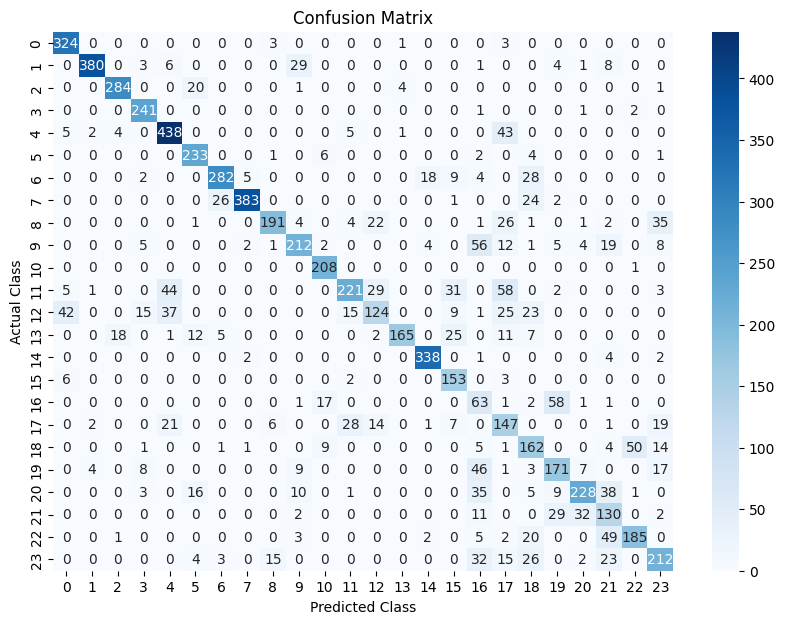

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       331
           1       0.98      0.88      0.93       432
           2       0.93      0.92      0.92       310
           3       0.87      0.98      0.92       245
           4       0.80      0.88      0.84       498
           5       0.81      0.94      0.87       247
           6       0.89      0.81      0.85       348
           7       0.97      0.88      0.92       436
           8       0.88      0.66      0.76       288
           9       0.78      0.64      0.70       331
          10       0.86      1.00      0.92       209
          11       0.80      0.56      0.66       394
          12       0.65      0.43      0.51       291
          13       0.96      0.67      0.79       246
          14       0.93      0.97      0.95       347
          15       0.65      0.93      0.77       164
          16       0.24      0.44      0.31       144
   

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_df_mnist_test_xgb, y_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
class_report = classification_report(y_df_mnist_test_xgb, y_preds)
print("Classification Report:\n", class_report)

### CNN model

In [14]:
# Normalize the data
X_df_mnist_train_norm = X_df_mnist_train / 255
X_df_mnist_test_norm = X_df_mnist_test / 255

## CNN model
X_df_mnist_train_reshape = np.array(X_df_mnist_train_norm).reshape(-1, 28, 28, 1)
X_df_mnist_test_reshape = np.array(X_df_mnist_test_norm).reshape(-1, 28, 28, 1)

## Ensure y_df_mnist_train and y_df_mnist_test are one-hot encoded
y_df_mnist_train_cnn = to_categorical(y_df_mnist_train) 
y_df_mnist_test_cnn = to_categorical(y_df_mnist_test)

In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_df_mnist_train_reshape)

# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

In [16]:
# Define the file name for the model
model_filename = base_dir / 'models' / 'cnn_model_mnist.h5'

# Check if the model file exists
model_file = Path(model_filename)

# Check if the model exists
if model_filename.is_file():
    # If the model exists, load it
    cnn_model = load_model(model_filename)
    print("Model loaded")
else:
    # If the model does not exist, build and train the CNN model
    print("Model does not exist. Training a new model...")

    # Build the CNN model
    cnn_model = Sequential()

    # First convolutional block
    cnn_model.add(Conv2D(64, (5, 5), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D((2, 2), strides=2))

    # Second convolutional block with SeparableConv2D
    cnn_model.add(SeparableConv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D((2, 2), strides=2))

    # Third convolutional block with SeparableConv2D
    cnn_model.add(SeparableConv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D((2, 2), strides=2))

    # Fourth convolutional block
    cnn_model.add(Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'))
    cnn_model.add(BatchNormalization())

    # Flatten and fully connected layers
    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(Dropout(0.4))  # Dropout for regularization

    # Output layer (assuming 25 classes)
    cnn_model.add(Dense(25, activation='softmax'))

    # Compile the model
    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Now you need to train the model (make sure you have your training data)
    # Train the model
    history = cnn_model.fit(
        datagen.flow(X_df_mnist_train_reshape, y_df_mnist_train_cnn, batch_size=128),
        epochs=10,
        validation_data=(X_df_mnist_test_reshape, y_df_mnist_test_cnn),
        callbacks=[learning_rate_reduction]
    )

    # After training, save the model
    cnn_model.save(model_filename)
    print("Model trained and saved")

Model loaded


In [17]:
# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_df_mnist_test_reshape, y_df_mnist_test_cnn)
print(f"Test accuracy: {test_accuracy}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 1.0000 - loss: 4.7730e-04
Test accuracy: 1.0


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


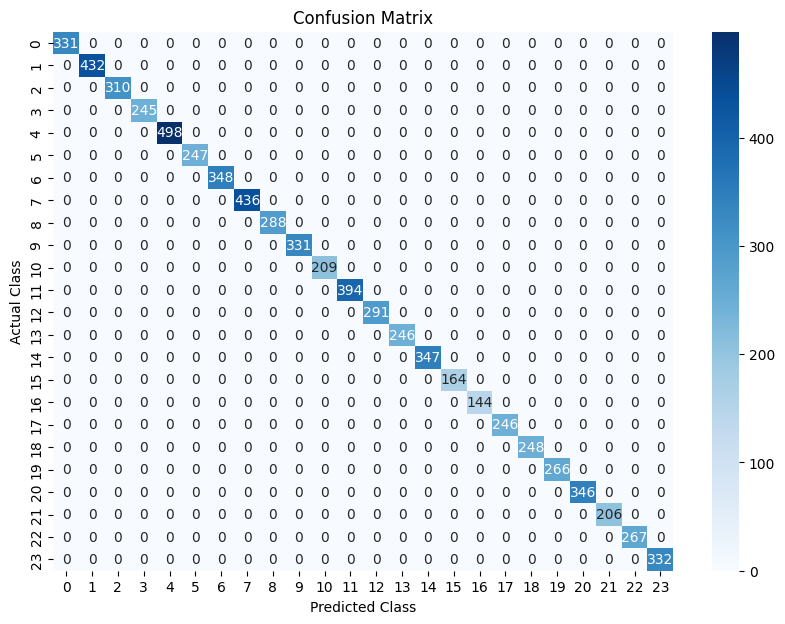

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       1.00      1.00      1.00       144
   

In [18]:
# Make predictions (cnn_model.predict returns probabilities, so we need to convert them to class labels)
y_preds_cnn = cnn_model.predict(X_df_mnist_test_reshape)

# Convert probabilities to predicted class labels
y_preds_cnn_classes = np.argmax(y_preds_cnn, axis=1)

# Convert true labels to integer class labels if they are one-hot encoded
# Assuming y_df_mnist_test_cnn is one-hot encoded, otherwise skip this
if len(y_df_mnist_test_cnn.shape) > 1:
    y_df_mnist_test_cnn_classes = np.argmax(y_df_mnist_test_cnn, axis=1)
else:
    y_df_mnist_test_cnn_classes = y_df_mnist_test_cnn

# Confusion Matrix
conf_matrix = confusion_matrix(y_df_mnist_test_cnn_classes, y_preds_cnn_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
class_report = classification_report(y_df_mnist_test_cnn_classes, y_preds_cnn_classes)
print("Classification Report:\n", class_report)

In [19]:
np.unique(y_preds_cnn_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [20]:
# Predict for a single test image
single_image = np.expand_dims(X_df_mnist_test_reshape[0], axis=0)

# Perform the prediction
prediction = cnn_model.predict(single_image)

# Print the prediction (class probabilities)
print(prediction)

# If you want to get the class with the highest probability:
predicted_class = np.argmax(prediction, axis=1)
print(f"Predicted class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[6.6056404e-16 3.0870881e-14 6.6832759e-12 1.6054720e-14 3.0247225e-11
  1.5071672e-13 1.0000000e+00 1.9314291e-08 6.2993470e-16 6.5038176e-18
  1.5922415e-12 5.7824237e-13 1.1788294e-12 8.8511582e-14 6.3768491e-12
  2.6302572e-14 1.2677526e-11 2.6997430e-15 5.9901011e-14 4.2793671e-09
  7.6699909e-15 1.8064792e-14 9.1954744e-16 4.5335046e-12 8.5213463e-15]]
Predicted class: 6


### Make Live Predictions

In [25]:
def run_trained_model(selected_model):
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands

    # Set up the MediaPipe Hands model
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # Open the video file or capture from webcam
    video_capture = cv2.VideoCapture(0)  # Replace with your video file path or use 0 for webcam

    # Output directory to save the cropped hand image
    output_dir = 'hand_images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    frame_counter = 0  # To keep track of the frame number

    while True:
        success, frame = video_capture.read()
        
        if not success:
            print("End of video or cannot read the frame.")
            break
        
        # Convert the frame to RGB (MediaPipe expects RGB images)
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame for hand tracking
        result = hands.process(img_rgb)

        prediction_text = ""

        # If hands are detected, crop and save the hand
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                # Get the image dimensions
                h, w, c = frame.shape
                
                # Calculate the bounding box for the hand
                x_min = w
                y_min = h
                x_max = 0
                y_max = 0
                
                # Iterate through the hand landmarks to get the bounding box
                for lm in hand_landmarks.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x < x_min: x_min = x
                    if y < y_min: y_min = y
                    if x > x_max: x_max = x
                    if y > y_max: y_max = y

                # Add some padding to the bounding box
                padding = 10
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(w, x_max + padding)
                y_max = min(h, y_max + padding)

                # Crop the hand region from the frame
                cropped_hand = frame[y_min:y_max, x_min:x_max]
                
                # Resize the cropped hand to 28x28 pixels (for prediction)
                if cropped_hand.size > 0:
                    img_hand_resized = cv2.resize(cropped_hand, (28, 28))

                    # Convert the resized hand to grayscale
                    gray_image = cv2.cvtColor(img_hand_resized, cv2.COLOR_BGR2GRAY)

                    # Perform the prediction
                    if selected_model == 'cnn':

                        # Normalize and expand dimensions to match the model's expected input shape
                        gray_image = gray_image.astype('float32') / 255.0  
                        gray_image = np.expand_dims(gray_image, axis=-1)  
                        gray_image = np.expand_dims(gray_image, axis=0)  
                        
                        # Make the prediction
                        prediction = cnn_model.predict(gray_image)

                        # If you want to get the class with the highest probability:
                        predicted_class = np.argmax(prediction, axis=1)  # Assuming prediction is 2D, else remove axis=1

                        # Transform the predicted class using the label encoder (le)
                        predicted_class_trans = le.transform([predicted_class[0]])[0]  # Apply transform to an array-like input and get the first element

                        # Store the prediction text to display on the frame
                        prediction_text = f'Predicted Label: {letters_dict_mnist[predicted_class_trans]}'
                    
                    elif selected_model == 'boost':
                        gray_image_flattened = gray_image.ravel().reshape(1, -1)

                        # Perform the prediction with the XGBoost model
                        prediction = xgb_model_mnist.predict(gray_image_flattened)

                        # Store the prediction text to display on the frame
                        prediction_text = f'Predicted Label: {letters_dict_mnist[prediction[0]]}'


        # Display the prediction on the frame
        if prediction_text:
            cv2.putText(frame, prediction_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show the video with prediction in a window
        cv2.imshow("Hand Gesture Recognition", frame)

        # Exit loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture and destroy all windowsq
    video_capture.release()
    cv2.destroyAllWindows()

In [26]:
# Select which model you would like to predict with
# run_trained_model('boost')
run_trained_model('cnn')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

## 21 points

### EDA

Sample images for letter A


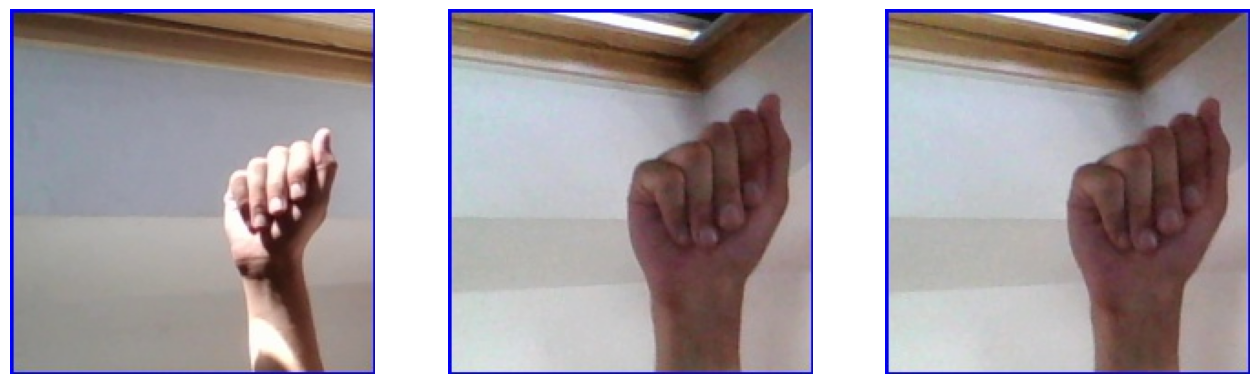

In [23]:
def plot_three_samples(letter):
    print("Sample images for letter " + letter)

    # Define the path to the subfolder for the given letter
    img_folder = base_dir / 'asl_alphabet_train' / 'asl_alphabet_train' / letter
    
    # Search for all images inside the letter's folder
    img_path = str(img_folder / '*.jpg')  # Search for all .jpg files in the letter folder
    
    # Get all image paths for the given letter using glob
    path_contents = sorted(glob(img_path))  # Sort the images for consistent order
    
    if len(path_contents) < 3:
        print(f"Not enough images found for letter {letter}. Found {len(path_contents)} images.")
        return
    
    # Select the first 3 images from the available images
    imgs = path_contents[3:6]
    
    # Display the images
    plt.figure(figsize=(16, 16))
    
    for i in range(3):  # Loop to display 3 images
        img = cv2.imread(imgs[i])
        if img is None:
            print(f"Could not read image {imgs[i]}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for plotting
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')  # Hide the axes for cleaner output
    
    plt.show()

    return img

# Example call to plot the first three samples for letter 'A'
img_letter = plot_three_samples('A')

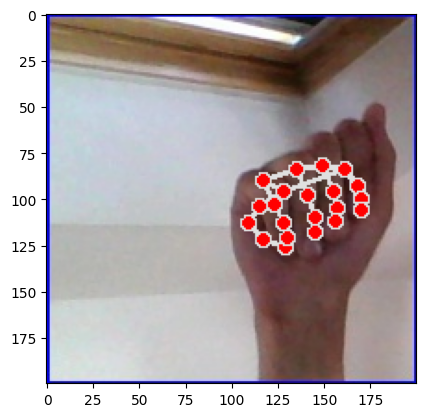

In [24]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

# Set up the MediaPipe Hands model
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Assume `img_letter` is your input image in RGB format
frame = img_letter  # Your RGB image

# Process the frame for hand tracking (no need for color conversion, it's already in RGB)
result = hands.process(frame)

# If hands are detected, draw landmarks and connections
if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        # Draw the landmarks on the original frame
        mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

# Convert the frame back to BGR for display with OpenCV
frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

# Display the frame with hand tracking
plt.imshow(frame_bgr)